### Vary dimension $p$
Vary the number of nodes $p$ and observe the error, bias, and time to run.
The number of samples scales with $(p+s) \log p$ for $s$ denoting the sparsity of the precision matrix.

In [2]:
from utils import *
from opt import *
from time import perf_counter


In [56]:
edge_prob = .2
DIM_RANGE = np.arange(10,50+1,10)
SPARS_RANGE = [ edge_prob*p*(p-1) for p in DIM_RANGE ]
SAMPLE_RANGE = [ 100 * int((p + SPARS_RANGE[i])*np.log(p)) for i,p in enumerate(DIM_RANGE) ]
num_params = len(DIM_RANGE)

g = 2

mu1 = .01
mu2 = .5
epsilon = 1e-6
bias_type = 'dp'
eta = .02
iters = 1000

num_trials = 10


In [57]:
bias_true = np.zeros((num_trials,num_params))

frob_err_glasso = np.zeros((num_trials,num_params))
f1_score_glasso = np.zeros((num_trials,num_params))
time_run_glasso = np.zeros((num_trials,num_params))
bias_glasso = np.zeros((num_trials,num_params))

frob_err_dp = np.zeros((num_trials,num_params))
f1_score_dp = np.zeros((num_trials,num_params))
time_run_dp = np.zeros((num_trials,num_params))
bias_dp = np.zeros((num_trials,num_params))

frob_err_nodewise = np.zeros((num_trials,num_params))
f1_score_nodewise = np.zeros((num_trials,num_params))
time_run_nodewise = np.zeros((num_trials,num_params))
bias_nodewise = np.zeros((num_trials,num_params))

for i,p in enumerate(DIM_RANGE):
    n = SAMPLE_RANGE[i]

    for t in range(num_trials):
        print(f"Dimension p = {p} | Trial {t+1} of {num_trials}")

        A = generate_connected_er(p,edge_prob)
        Sigma, Theta = create_mtp2_cov(A)
        Theta_od = Theta*(1-np.eye(p))
        X = np.random.multivariate_normal(np.zeros(p), Sigma, n)
        Sigma_hat = X.T@X/n

        z = np.ones(p, dtype=int)
        z[:int(p/2)] = 0
        Z = np.eye(g)[z].T
        bias_true[t,i] = compute_dp2(Theta,Z)

        tic = perf_counter()
        Theta_glasso = node_FGL_fista(Sigma_hat, mu1, eta, 0, Z, 'dp', epsilon, iters, False)
        toc = perf_counter()
        frob_err_glasso[t,i] = compute_frob_err(Theta_glasso, Theta)
        f1_score_glasso[t,i] = compute_f1_score(Theta_glasso, Theta,.1)
        time_run_glasso[t,i] = np.abs(toc-tic)
        bias_glasso[t,i] = compute_dp2(Theta_glasso, Z)
        print( '    ' +
            'GLASSO: ' + 
            f'Err: {frob_err_glasso[t,i]:.4f} | ' +
            f'F1: {f1_score_glasso[t,i]:.4f} | ' +
            f'Time: {time_run_glasso[t,i]:.4f} | ' +
            f'Bias: {bias_glasso[t,i]:.4f}')

        tic = perf_counter()
        Theta_dp = node_FGL_fista(Sigma_hat, mu1, eta, mu2, Z, 'dp', epsilon, iters, False)
        toc = perf_counter()
        frob_err_dp[t,i] = compute_frob_err(Theta_dp, Theta)
        f1_score_dp[t,i] = compute_f1_score(Theta_dp, Theta,.1)
        time_run_dp[t,i] = np.abs(toc-tic)
        bias_dp[t,i] = compute_dp2(Theta_dp, Z)
        print( '    ' +
            'DP:     ' + 
            f'Err: {frob_err_dp[t,i]:.4f} | ' +
            f'F1: {f1_score_dp[t,i]:.4f} | ' +
            f'Time: {time_run_dp[t,i]:.4f} | ' +
            f'Bias: {bias_dp[t,i]:.4f}')

        tic = perf_counter()
        Theta_nodewise = node_FGL_fista(Sigma_hat, mu1, eta, mu2, Z, 'nodewise', epsilon, iters, False)
        toc = perf_counter()
        frob_err_nodewise[t,i] = compute_frob_err(Theta_nodewise, Theta)
        f1_score_nodewise[t,i] = compute_f1_score(Theta_nodewise, Theta,.1)
        time_run_nodewise[t,i] = np.abs(toc-tic)
        bias_nodewise[t,i] = compute_dp2(Theta_nodewise, Z)
        print( '    ' +
            'Nw. DP: ' + 
            f'Err: {frob_err_nodewise[t,i]:.4f} | ' +
            f'F1: {f1_score_nodewise[t,i]:.4f} | ' +
            f'Time: {time_run_nodewise[t,i]:.4f} | ' +
            f'Bias: {bias_nodewise[t,i]:.4f}')



Dimension p = 10 | Trial 1 of 10
    GLASSO: Err: 0.0036 | F1: 1.0000 | Time: 0.2130 | Bias: 0.0059
    DP:     Err: 0.0039 | F1: 1.0000 | Time: 0.1434 | Bias: 0.0049
    Nw. DP: Err: 0.0047 | F1: 1.0000 | Time: 0.4794 | Bias: 0.0042
Dimension p = 10 | Trial 2 of 10
    GLASSO: Err: 0.0037 | F1: 1.0000 | Time: 0.2130 | Bias: 0.0196
    DP:     Err: 0.0048 | F1: 1.0000 | Time: 0.1442 | Bias: 0.0146
    Nw. DP: Err: 0.0046 | F1: 1.0000 | Time: 0.4751 | Bias: 0.0167
Dimension p = 10 | Trial 3 of 10
    GLASSO: Err: 0.0039 | F1: 1.0000 | Time: 0.2101 | Bias: 0.0062
    DP:     Err: 0.0041 | F1: 1.0000 | Time: 0.1428 | Bias: 0.0040
    Nw. DP: Err: 0.0051 | F1: 1.0000 | Time: 0.4816 | Bias: 0.0041
Dimension p = 10 | Trial 4 of 10
    GLASSO: Err: 0.0075 | F1: 0.9730 | Time: 0.2118 | Bias: 0.0119
    DP:     Err: 0.0083 | F1: 0.9444 | Time: 0.1431 | Bias: 0.0072
    Nw. DP: Err: 0.0127 | F1: 0.9444 | Time: 0.4835 | Bias: 0.0106
Dimension p = 10 | Trial 5 of 10
    GLASSO: Err: 0.0044 | F1: 1

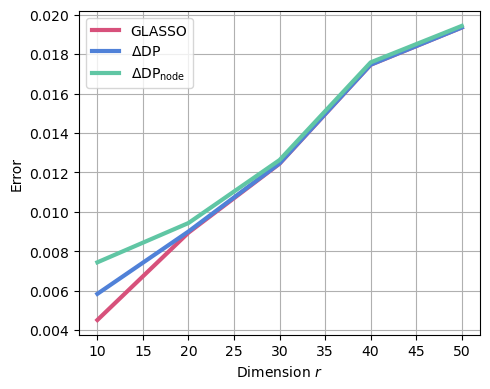

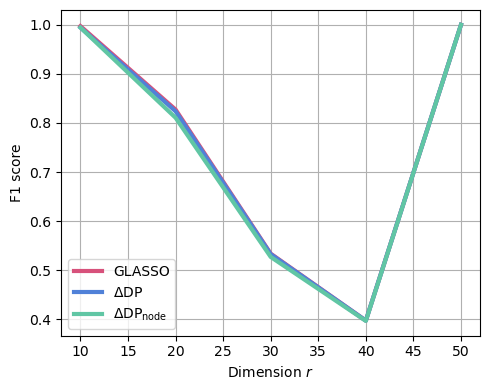

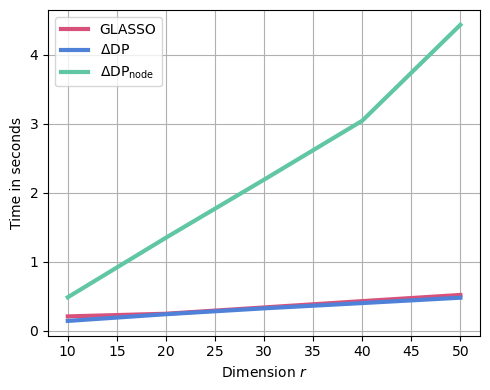

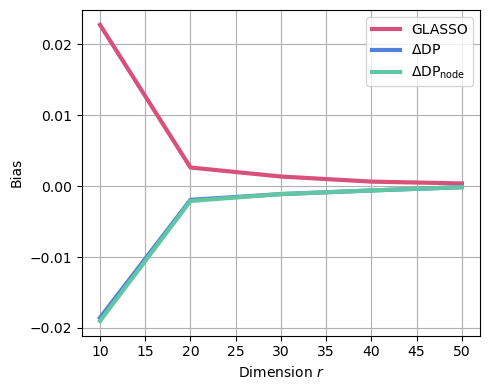

In [58]:
x_label = r'Dimension $r$'
x_range = DIM_RANGE

plt_args = { 'linewidth':3 }

y_label = 'Error'
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()

y_range = frob_err_glasso.mean(0)
ax.plot(x_range, y_range, c=reds[10], **plt_args, label='GLASSO')

y_range = frob_err_dp.mean(0)
ax.plot(x_range, y_range, c=blues[10], **plt_args, label=r'$\Delta \mathrm{DP}$')

y_range = frob_err_nodewise.mean(0)
ax.plot(x_range, y_range, c=greens[10], **plt_args, label=r'$\Delta \mathrm{DP}_{\mathrm{node}}$')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()



y_label = 'F1 score'
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()

y_range = f1_score_glasso.mean(0)
ax.plot(x_range, y_range, c=reds[10], **plt_args, label='GLASSO')

y_range = f1_score_dp.mean(0)
ax.plot(x_range, y_range, c=blues[10], **plt_args, label=r'$\Delta \mathrm{DP}$')

y_range = f1_score_nodewise.mean(0)
ax.plot(x_range, y_range, c=greens[10], **plt_args, label=r'$\Delta \mathrm{DP}_{\mathrm{node}}$')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()

y_label = 'Time in seconds'
y_range = time_run_glasso.mean(0)
clr = greens[10]
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()

y_range = time_run_glasso.mean(0)
ax.plot(x_range, y_range, c=reds[10], **plt_args, label='GLASSO')

y_range = time_run_dp.mean(0)
ax.plot(x_range, y_range, c=blues[10], **plt_args, label=r'$\Delta \mathrm{DP}$')

y_range = time_run_nodewise.mean(0)
ax.plot(x_range, y_range, c=greens[10], **plt_args, label=r'$\Delta \mathrm{DP}_{\mathrm{node}}$')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()

y_label = 'Bias'
# y_range = bias_glasso.mean(0)
y_range = bias_glasso.mean(0) - bias_true.mean(0)
clr = purples[10]
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()

y_range = bias_glasso.mean(0)
ax.plot(x_range, y_range, c=reds[10], **plt_args, label='GLASSO')

# y_range = bias_dp.mean(0)
y_range = bias_dp.mean(0) - bias_true.mean(0)
ax.plot(x_range, y_range, c=blues[10], **plt_args, label=r'$\Delta \mathrm{DP}$')

# y_range = bias_nodewise.mean(0)
y_range = bias_nodewise.mean(0) - bias_true.mean(0)
ax.plot(x_range, y_range, c=greens[10], **plt_args, label=r'$\Delta \mathrm{DP}_{\mathrm{node}}$')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()
